In [21]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import math
from scipy import interpolate
pd.set_option('display.max_columns', 5000)  # or 1000
pd.set_option('display.max_rows', 5000)  # or 1000
import time
from numpy import concatenate
import matplotlib.pyplot as plt

In [2]:
Lake_name = input('Lake name:')
os.chdir('Lakes\\'+Lake_name)

Lake name:Erken


In [34]:
file_name = input('File name:')
Meteo = pd.read_excel(file_name+'.xlsx',sheet_name='1a Met Data',parse_dates=['Date'],skiprows=[1])
Prec = pd.read_excel(file_name+'.xlsx',sheet_name = '1c Precip',parse_dates = ['Date'],skiprows = [1])
Temp = pd.read_excel(file_name+'.xlsx',sheet_name = '1b temp profiles',parse_dates = ['Date'])
Nut = pd.read_excel(file_name+'.xlsx',sheet_name = '2 Nutrients Chl',parse_dates = ['Date'],skiprows = [1])
inflow = pd.read_excel(file_name+'.xlsx',sheet_name = '3a Discharge',parse_dates = ['Date'])
Ice = pd.read_excel(file_name+'.xlsx',sheet_name = '3b Ice',parse_dates = ['Date of iceon','Date of iceoff'])

File name:Vansjø_dataset_BLOOWATER


# Prepare Meteorological data

In [35]:
Meteo['RelHum'] = 100*np.exp((17.625*Meteo['DewPoint Temp'])/(243.04+Meteo['DewPoint Temp']))/np.exp((17.625*Meteo['Air T'])/(243.04+Meteo['Air T']))

In [36]:
Meteo = Meteo.merge(Prec,on = 'Date',how = 'inner')[['Date','u10','v10','Air pressure','Air T','RelHum','SWR','CloudCover','Precip']]
Meteo.columns = ['!Date','u10','v10','Air P','Air T','RelHum','SWR','CC','Prec']
Meteo['!Date'] = Meteo['!Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [36]:
PB_folder = input('Process-based model folder:')
os.chdir(PB_folder)
Meteo.to_csv('Vansjø_meteo.dat',index = False,sep = '\t')

Process-based model folder:C:\small_array_working_area\Shuqi\Lake Vansjø


# Prepare temperature intial data

In [37]:
Depth = Temp.columns[1:].values.astype(str)
Depth = np.char.strip(Depth,'T')
Depth = np.char.strip(Depth,'m')
Depth = [d.replace("_",'.') for d in Depth]
Depth = np.array(list(map(float,Depth)))
Temp_int = pd.DataFrame(Temp.iloc[0,1:].values,index = -Depth)

In [135]:
os.chdir(PB_folder)
Temp_int.to_csv('Vansjø_Temp.dat',header=[str(Temp['Date'].iloc[0])+' '+str(Temp.shape[1]-1)+' '+str(2)],sep = '\t')

# Prepare inflow data

In [7]:
inflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 8 columns):
Date                               8035 non-null datetime64[ns]
Observed Q at Kure (m3/s)          8035 non-null float64
Mod Q at Store inflow (m3/s)       8035 non-null float64
Mod WaterTemp Store inflow         8035 non-null float64
Mod Q from store outflow (m3/s)    8035 non-null float64
Mod Water Temp Store outflow       8035 non-null float64
Mod Q from vanem catch (m3/s)      8035 non-null float64
Mod Water temp vanem catch         8035 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 502.3 KB


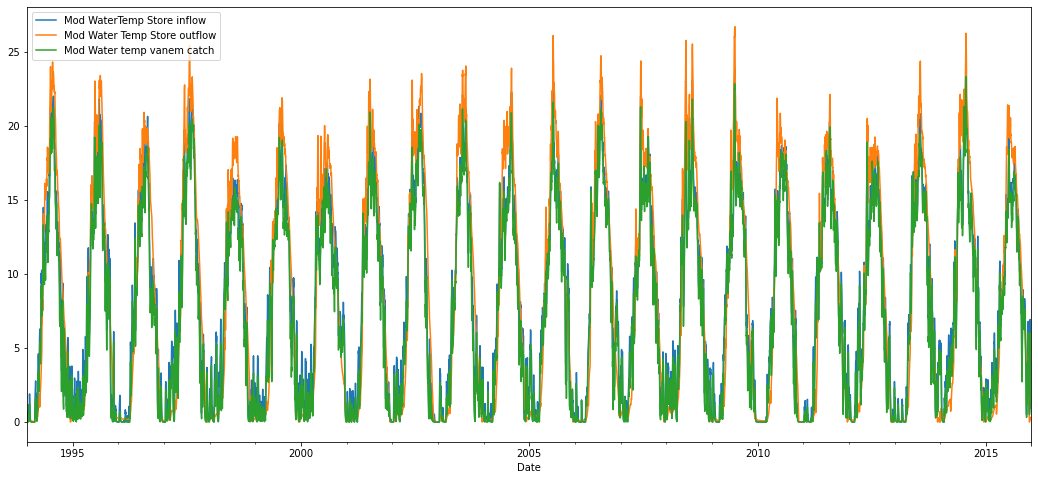

In [144]:
inflow.plot(x = 'Date',y = ['Mod WaterTemp Store inflow','Mod Water Temp Store outflow','Mod Water temp vanem catch'],figsize = (18,8))

In [150]:
Kure = inflow[['Date','Observed Q at Kure (m3/s)']]
Kure.columns=['!Time','Inflow (m3/s)']
Kure['!Time'] = Kure['!Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
Kure.to_csv('Kure_input.dat',sep = '\t',index = False)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
Store = inflow[['Date','Mod WaterTemp Store inflow','Mod WaterTemp Store inflow']]
Store.columns = ['!Time','Inflow (m3/s)','Temp C']
Store['!Time'] = Store['!Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
Store.to_csv('Store_input.dat',sep = '\t',index = False)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [156]:
vanem = inflow[['Date','Mod Q from vanem catch (m3/s)','Mod Water temp vanem catch']]
vanem.columns = ['!Time','Inflow (m3/s)','Temp C']
vanem['!Time'] = vanem['!Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
vanem.to_csv('vanem_input.dat',sep = '\t',index = False)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [159]:
Store_out = inflow[['Date','Mod Q from store outflow (m3/s)','Mod Water Temp Store outflow']]
Store_out.columns = ['!Time','outflow (m3/s)','Temp C']
Store_out['!Time'] = Store_out['!Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
Store_out['outflow (m3/s)'] = Store_out['outflow (m3/s)']*-1
Store_out.to_csv('Store_out.dat',sep = '\t',index = False)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Prepare temperature calibration file

In [38]:
new_col = list(Depth)
new_col.insert(0,'Date')

In [39]:
Temp.columns = new_col
Temp_ob = pd.melt(Temp,id_vars = 'Date',value_vars=Depth[1:])
Temp_ob['Date'] = Temp_ob['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
Temp_ob.columns = ['Date', 'Depth', 'temp C']
Temp_ob['Depth'] = Temp_ob['Depth']*-1

In [179]:
os.chdir(PB_folder+'\calibration')
Temb_ob.to_csv('Vansj_temperature.obs',header = False,index = False,sep='\t')

# Prepare input file for Lake_Analyzer

In [ ]:
Depth_new = []
for i in Depth:
    Depth_new.append('wrt_'+str(i))
Depth_new.insert(0,'dateTime')
Temp_la = Temp.copy()
Temp_la.columns = Depth_new
Temp_la['dateTime'] = Temp_la['dateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [40]:
LA_folder = input('LakeAnalyzer folder:')
os.chdir(LA_folder)

LakeAnalyzer folder:C:\small_array_working_area\Shuqi\Lake-Analyzer-master\Lake-Analyzer\Data


In [37]:
Temp_la.to_csv(Lake_name+'.WTR',index = False,sep='\t')

LakeAnalyzer folder:C:\small_array_working_area\Shuqi\Lake-Analyzer-master\Lake-Analyzer\Data


In [46]:
wind = Meteo[['!Date','u10','v10']]
wind['windSpeed'] = np.sqrt(wind['u10']**2+wind['v10']**2)
wind.rename(columns={'!Date':'dateTime'})
wind.drop(['u10','v10'],axis = 1,inplace = True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
wind.to_csv(Lake_name+'.WND',index = False,sep='\t')

# Extract Lake_Analyzer results

Name of LA result file:Lake Vansjø_results


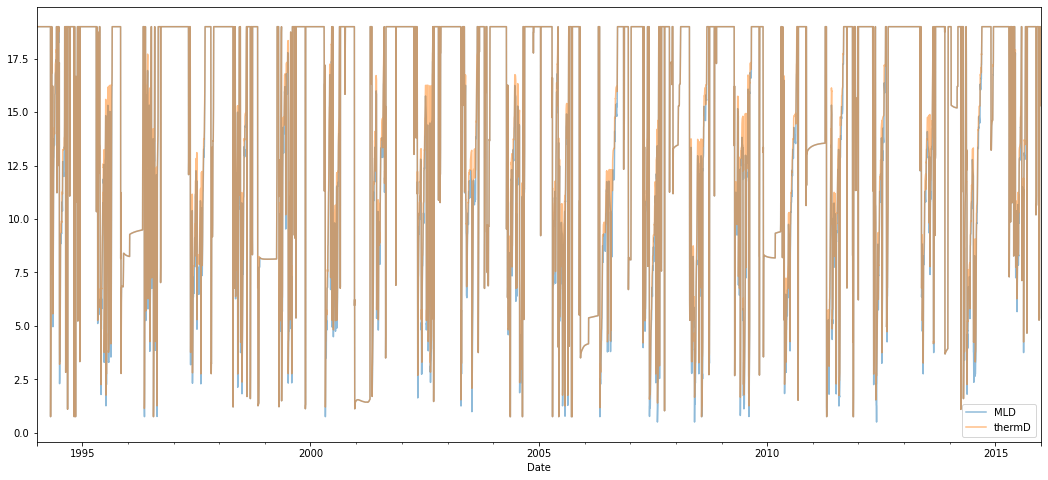

In [41]:
os.chdir(LA_folder)
LA_filename = input('Name of LA result file:')
LA_results= pd.read_csv(LA_filename+'.txt',sep = '\t',parse_dates = ['DateTime'])
LA_results.columns = ['Date','W','MLD','thermD']
LA_results.plot(x = 'Date',y = ['MLD','thermD'],alpha = 0.5,figsize = (18,8))

In [42]:
# Compute water density according to temperature
a = Temp.iloc[:,1:]+288.9414
b = 508929.2*(Temp.iloc[:,1:]+68.12963)
c = (Temp.iloc[:,1:]-3.9863)**2
rho = (1-(a/b)*c)*1000
rho.index = Temp['Date']
rho.reset_index(inplace = True)

In [43]:
hypso = pd.read_csv(Lake_name+'.BTH')

In [44]:
# Compute Wedderburn number based on MLD
fetch= np.sqrt(hypso.iloc[0,1]/np.pi)
U2 = np.array(Meteo['u10'])**2
rho_e = np.empty((LA_results.shape[0],1))
rho_e[:] = np.nan
tau= np.empty((LA_results.shape[0],1))
tau[:] = np.nan
rho_a = Meteo['Air P']*100/(287.058*(Meteo['Air T']+273.15))

for t in range(LA_results.shape[0]):
    rho_e[t] = np.mean(rho.iloc[t,1:len(Depth[rho.columns[1:].values<=LA_results['MLD'][0]])])
    if np.sqrt(U2[t])<5:tau[t] = 1e-3*rho_a[t]*U2[t] 
    else:tau[t] =1.5e-3*rho_a[t]*U2[t]

In [45]:
u_star = np.sqrt(tau/rho_e)

rho_h = np.array(rho.iloc[:,-1]).reshape(LA_results.shape[0],1)  # use the density of bottom layer to represent hypolimnion water density
del_rho = np.abs(rho_e-rho_h) 
reduced_g = 9.8*del_rho/rho_h

W = reduced_g*np.array(LA_results['MLD']).reshape(LA_results.shape[0],1)**2/(u_star**2*fetch)
LA_results['W'] = W
LA_results['W'] = LA_results['W'].apply(lambda w:np.nan if w>1000 else w)

# Prepare Daily_observation_df for ML algorithms

In [46]:
Daily_df = Meteo.copy()
Daily_df['U'] = np.sqrt(Daily_df['u10']**2+Daily_df['v10']**2)
Daily_df.drop(['u10','v10'],axis = 1,inplace = True)
Daily_df.rename(columns = {'!Date':'Date','Air P':'AirP','Air T':'AirT'},inplace=True)
Daily_df['delT'] = abs(Temp.iloc[:,1:5].mean(axis = 1)-Temp.iloc[:,-1]) # delT = temp(suf)-temp(bot); temp(suf) is mean over surface 2m 
Daily_df['Date'] = pd.to_datetime(Daily_df['Date'])

In [47]:
print(inflow.info())
num_inflow = int(input('Number of inflows:'))
inflow_idx = [0]
for i in range(num_inflow):
    inflow_idx.append(int(input('Inflow column index:')))

num_outflow = int(input('Number of outflows:'))
outflow_idx = [0]
for i in range(num_outflow):
    outflow_idx.append(int(input('Outflow column index:')))

Daily_inflow = inflow.iloc[:,inflow_idx]
Daily_inflow['inflow(m3/s)'] = Daily_inflow.iloc[:,1:num_inflow+1].sum(axis = 1)
Daily_inflow.drop(Daily_inflow.columns[list(np.arange(1,num_inflow+1,1))],axis = 1,inplace = True)

Daily_outflow = inflow.iloc[:,outflow_idx]
Daily_outflow['outflow(m3/s)'] = Daily_outflow.iloc[:,1:num_outflow+1].sum(axis = 1)
Daily_outflow.drop(Daily_outflow.columns[list(np.arange(1,num_outflow+1,1))],axis = 1,inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 8 columns):
Date                               8035 non-null datetime64[ns]
Observed Q at Kure (m3/s)          8035 non-null float64
Mod Q at Store inflow (m3/s)       8035 non-null float64
Mod WaterTemp Store inflow         8035 non-null float64
Mod Q from store outflow (m3/s)    8035 non-null float64
Mod Water Temp Store outflow       8035 non-null float64
Mod Q from vanem catch (m3/s)      8035 non-null float64
Mod Water temp vanem catch         8035 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 502.3 KB
None
Number of inflows:3
Inflow column index:1
Inflow column index:2
Inflow column index:6
Number of outflows:1
Outflow column index:4


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [48]:
Daily_df = Daily_df.merge(Daily_inflow,on = 'Date',how = 'inner').merge(Daily_outflow,on = 'Date',how = 'inner')

In [49]:
Ice['Ice_d'] = (Ice['Date of iceoff']-Ice['Date of iceon']).dt.days
ice_d = []
for i in Daily_df['Date']:
    yy = i.year
    ice_d.append(Ice[Ice['Year']==yy]['Ice_d'].values)
Daily_df['Ice_d'] = np.array(ice_d)

def d_from_iceoff(date):
    yy = date.year
    days = (date - Ice[Ice['Year']==yy]['Date of iceoff']).values.astype('timedelta64[D]')
    return (days/np.timedelta64(1, 'D'))[0]
Daily_df['days from iceoff'] = Daily_df['Date'].map(lambda date:d_from_iceoff(date))

In [50]:
Daily_df = Daily_df.merge(LA_results,on='Date',how = 'inner')
Training_folder = input('Training folder:')
os.chdir(Training_folder)
lakename = input('Name of lake in short:')
Daily_df.to_csv(lakename+'_Daily_Observation_df.csv',sep='\t',index = False)

Training folder:C:\small_array_working_area\Shuqi\Algal-bloom-prediction-machine-learning\Trainning data
Name of lake in short:LV


In [51]:
## Remove winter data
Daily_df['MM'] = Daily_df['Date'].apply(lambda d:d.month)
Daily_df_nw=Daily_df[(Daily_df['MM']>=3)&(Daily_df['MM']<12)]
Daily_df_nw.to_csv(lakename+'_Daily_Observation_df_nowinter.csv',sep='\t',index = False)

# Prepare Observation_df for ML algorithms

In [52]:
df = Nut.merge(Daily_df,on = 'Date',how = 'left')

In [53]:
df.to_csv(lakename+'_Observation_df.csv',sep='\t',index = False)

In [54]:
## Remove winter data
df['MM'] = df['Date'].apply(lambda d:d.month)
df_nw=df[(df['MM']>=3)&(df['MM']<12)]
df_nw.to_csv(lakename+'_Observation_df_nowinter.csv',sep='\t',index = False)

In [3]:
os.chdir('Lakes\\Ekoln')
Daily_observation=pd.read_csv('Daily_Observation_df_nowinter.csv',sep=',',parse_dates=['Date'])

,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wdir,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,MM
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,330.0,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,6
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,240.0,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,6
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,320.0,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,6
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,160.0,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,6
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,50.0,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,280.0,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,11
8704,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,360.0,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,11
8705,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,290.0,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,11
8706,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,220.0,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,11


In [15]:
all_df = pd.read_csv('Observation_df_nowinter.csv',sep = ',')

In [17]:
all_df.to_csv('Observation_df_nowinter.csv',sep = '\t',index=False)

# Change to classification question

In [37]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
print('Input data of all the lakes can be found in Training data folder.')
filename = input('Input data file name (without .csv): ')
all_df = pd.read_csv(filename+'.csv',sep = '\t',parse_dates = ['Date'])
daily_df= pd.read_csv(lakename+'_Daily_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Trainning data
Load training data (containing nutrient observations)
Lake name in short: Erken
Input data of all the lakes can be found in Training data folder.
Input data file name (without .csv): Erken_Observation_df_nowinter6


In [38]:
print(all_df.columns)
Nut_num = int(input('How many nutrients to predict? (include Chl and put them in order) '))
Nut=[]
for i in range(Nut_num):
    Nut.append(input('Nut_'+str(i+1)+': '))

Index(['Date', 'NOX', 'DO_sur', 'PO4', 'TotP', 'NH4', 'Si', 'Chl', 'SST',
       'delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec', 'SWR', 'inflow',
       'outflow', 'MM', 'Ice_d', 'days from iceoff', 'thermD', 'MLD', 'W',
       'DO_bot'],
      dtype='object')
How many nutrients to predict? (include Chl and put them in order) 8
Nut_1: NOX
Nut_2: DO_sur
Nut_3: DO_bot
Nut_4: PO4
Nut_5: TotP
Nut_6: NH4
Nut_7: Si
Nut_8: Chl


In [39]:
all_df=all_df[['Date']+Nut].merge(daily_df,on=['Date'],how='right')

In [40]:
OB=all_df[['Date','Chl']].dropna()
OB['YY']=OB['Date'].apply(lambda d:d.year)
yy=OB['YY'].unique()
sam_int=[]
for i in range(len(yy)):
    sam_int.append(OB[OB['YY']==yy[i]]['Date'].diff().mean().days)
print('Averaged sample interval: {}'.format(round(np.nanmean(sam_int))))

sam_int=pd.DataFrame(sam_int,index=yy,columns=['Sample_interval'])

Averaged sample interval: 6


Threshold of delta_Chl:0.3
Threshold of Chl:5
Name of Chl variable: Chl
No bloom: 91.93 %, bloom: 8.07 %.


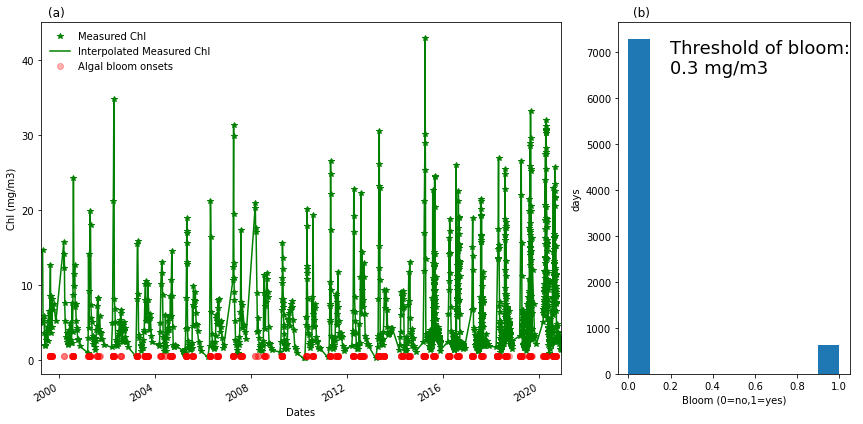

In [41]:
threshold1 = float(input('Threshold of delta_Chl:'))
threshold2 = float(input('Threshold of Chl:'))
def find_bloom(x):
    if (x['delta_Chl']>threshold1)&(x[Chl_name]>threshold2):
        return 1
    else:
        return 0

Chl_name=input('Name of Chl variable: ')
OB=all_df[['Date',Chl_name]]
OB=OB[~OB['Date'].duplicated()]
OB_int = OB.set_index('Date').reindex(pd.date_range(start =OB['Date'].iloc[0],end = OB['Date'].iloc[-1],freq = '1D')).interpolate(method = 'linear')
OB_int = OB_int.reset_index()
OB_int.columns = ['Date',Chl_name]
OB_int['Date'] = OB_int['Date'].apply(lambda d:d.date())
OB_int['Date'] = pd.to_datetime(OB_int['Date'])
# Use the delta_Chl threshold to find the onset dates of algal bloom
OB_int['delta_Chl'] = np.diff(OB_int[Chl_name],append=0)
OB_int['Bloom'] = OB_int.apply(lambda x: find_bloom(x), axis=1) 
OB_bloom = OB_int[['Date','Bloom']]
fig=plt.figure(tight_layout='pad',figsize = (12,6))

gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])
OB_bloom['Bloom'].hist(grid=False,ax=ax2)
OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
OB_int.plot(x = 'Date',y = Chl_name,style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ax1.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'ro',alpha=0.3,label='Algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Chl (mg/m3)')
ax1.set_xlim(OB['Date'].iloc[0],OB['Date'].iloc[-1])
ax1.set_title('(a)',x=0.03)
ax2.set_xlabel('Bloom (0=no,1=yes)')
ax2.set_ylabel('days')
ax2.set_title('(b)',x=0.1)
fig.text(0.78,0.9,'Threshold of bloom: \n'+str(threshold1)+' mg/m3',fontsize=18,
         horizontalalignment='left',
         verticalalignment='top')
print('No bloom: {} %, bloom: {} %.'.format(round(OB_bloom['Bloom'].value_counts()[0]/len(OB_bloom['Bloom'])*100,2),
                                            round(OB_bloom['Bloom'].value_counts()[1]/len(OB_bloom['Bloom'])*100,2)))

In [42]:
OB_bloom['MM']=OB_bloom['Date'].apply(lambda d:d.month)
OB_bloom=OB_bloom[(OB_bloom['MM']<12)&(OB_bloom['MM']>2)].merge(all_df,
                                                       on=['Date','MM'],
                                                       how='right')
OB_bloom['Bloom']=pd.Categorical(OB_bloom['Bloom'])

C:\Users\shuli278\AppData\Local\Temp/ipykernel_13548/4082898035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OB_bloom['MM']=OB_bloom['Date'].apply(lambda d:d.month)


In [43]:
OB_bloom.to_csv(lakename+'_Observation_df_nowinter_classification2.csv',sep='\t',index=False)